**This notebook is modified for UBC MDS-MDA Capstone project based on the eval.py code from this [repo](https://github.com/tylin/coco-caption/blob/master/pycocoevalcap/eval.py)**

In [70]:
import json
import pandas as pd
import numpy as np

## 1. Import metric scripts

In [71]:
# import metric scripts
import sys
sys.path.append('../scr/evaluation/')
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

In [72]:
# download Stanford models
!../scr/evaluation/get_stanford_models.sh

Found Stanford CoreNLP.


## 2. Load reference captions and generated captions

In [73]:
# reference captions
ref_path = '../data/processed/json/'
with open(ref_path + 'valid.json', 'r') as jsonFile:
    data = json.load(jsonFile)
    
# generated captions
results_path = '../models'
with open(results_path + '/' + 'test_results.json', 'r') as f:
    results = json.load(f)

## 3. Format the inputs and tokenize

In [76]:
# format the inputs
img_id_dict = {'image_id': list(data.keys())}

imgIds = img_id_dict['image_id']
gts = {}
res = {}

required_key = { 'raw', 'imgid', 'sentid' }

for imgId in imgIds:
    caption_list = data[imgId]['sentences']
    caption_list_sel = []
    for i in caption_list:
        lst = { key:value for key,value in i.items() if key in required_key}
        lst['caption'] = lst.pop('raw')
        lst['image_id'] = lst.pop('imgid')
        lst['id'] = lst.pop('sentid')
        caption_list_sel.append(lst)
    gts[imgId] = caption_list_sel
    
    generated = [{'caption': results[imgId]}]
    res[imgId] = generated

In [77]:
# tokenize
print('tokenization...')
tokenizer = PTBTokenizer()
gts  = tokenizer.tokenize(gts)
res = tokenizer.tokenize(res)

tokenization...


## 4. Evaluate the model results

In [81]:
def compute_score(reference, generated):
    """
    compute the evaluation metrics for the model
    
    Parameters
    -----------
    reference: dict
        a dictionary contains all the reference captions
    
    generated: dict
        a dictionary contains all the generated captions
    
    Returns
    ----------
    a dict showing the overall model scores
    a dict showing the individual image scores
    """
    scorers = [
    (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
    (Meteor(),"METEOR"),
    (Rouge(), "ROUGE_L"),
    (Cider(), "CIDEr"),
    (Spice(), "SPICE")
    ]
    score_dict = {}
    scores_dict = {}
    for scorer, method in scorers:
        print('computing %s score...'%(scorer.method()))
        score, scores = scorer.compute_score(reference, generated)
        if type(method) == list:
            for sc, scs, m in zip(score, scores, method):
                score_dict[m] = sc
                scores_dict[m] = scs
        else:
            score_dict[method] = score
            scores_dict[method] = scores
            
    # format the individual scores
    img_score_dict = {}
    for n in range(len(generated)):
        img_name = list(generated.keys())[n]
        img_score_dict[img_name] = {}
        for metrics in scores_dict.keys():
            if metrics == 'SPICE':
                img_score_dict[img_name][metrics] = scores_dict[metrics][n]['All']['f']
            else:
                img_score_dict[img_name][metrics] = scores_dict[metrics][n]
                
    return score_dict, img_score_dict, scores_dict

In [82]:
# View the overall average score for the model
model_score, img_score, scores_dict = compute_score(gts,res)
result_df = pd.DataFrame(model_score, index = ['Baseline model']).T
result_df

computing Bleu score...
{'testlen': 21524, 'reflen': 21224, 'guess': [21524, 19440, 17356, 15272], 'correct': [13527, 7790, 5135, 3541]}
ratio: 1.014134941575527
computing METEOR score...
computing Rouge score...
computing CIDEr score...
computing SPICE score...


,Baseline model
Bleu_1,0.628461
Bleu_2,0.501834
Bleu_3,0.420795
Bleu_4,0.362544
METEOR,0.289759
ROUGE_L,0.535357
CIDEr,2.050211
SPICE,0.379176


In [86]:
# save the evaluation results into json data
save_path = '../models/'
with open(save_path + 'baseline_score.json', 'w') as fp:
    json.dump(model_score, fp)
    
with open(save_path + 'baseline_img_score.json', 'w') as fp1:
    json.dump(img_score, fp1)

## Distribution of scores

In [129]:
spice_list = [img['All']['f'] for img in scores_dict['SPICE']]
scores_dict['SPICE'] = spice_list

In [130]:
import matplotlib.pyplot as plt
def hist_score(metric):
    
    plt.hist(scores_dict[metric])
    plt.title('Histogram of ' + metric + ' Scores', fontsize=20)
    plt.xlabel(metric +' score', fontsize=20)
    plt.ylabel('result counts', fontsize=20)
    plt.show()

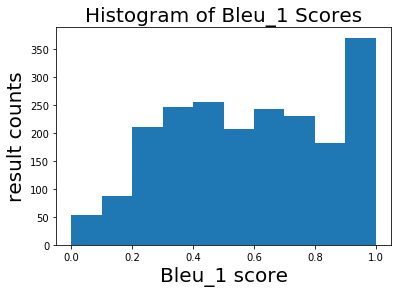

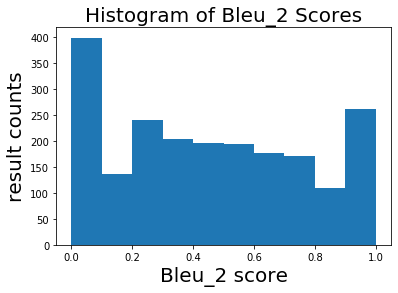

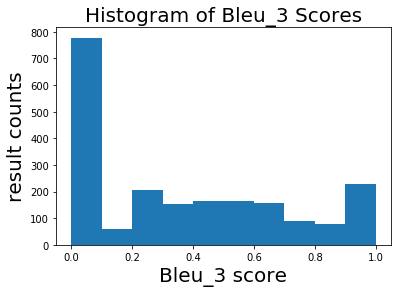

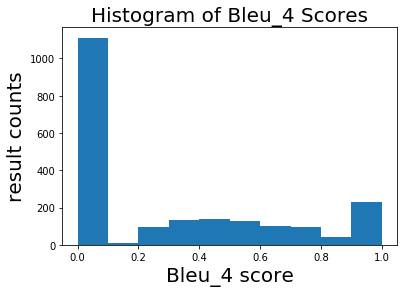

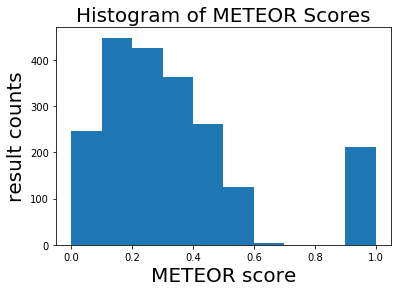

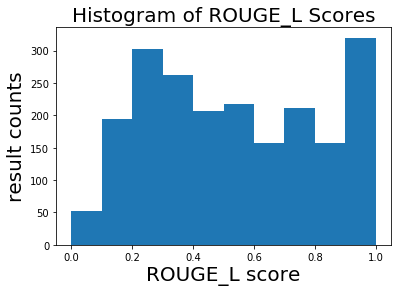

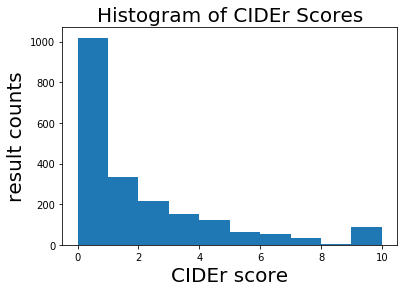

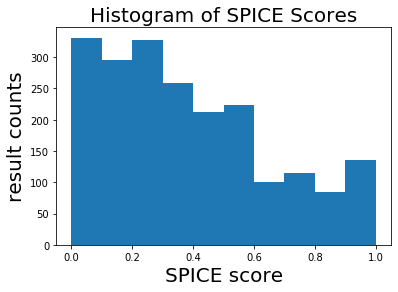

In [131]:
for metric in scores_dict.keys():
    hist_score(metric)